In [2]:
from typing import List, Tuple
import getpass
import numpy as np
from mnist import MNIST
from skimage.util.shape import view_as_windows
import math
from IPython.display import clear_output
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Sampler
from qiskit.circuit import Parameter
from qiskit.circuit.library import UGate, RXGate, RYGate, RZGate, TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA, CG, ADAM, AQGD, SLSQP
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [5]:
channel = "ibm_quantum"
try:
    service = QiskitRuntimeService(channel=channel)
except Exception:
    QiskitRuntimeService.save_account(channel=channel, token=getpass.getpass('Enter IBM Quantum token'), overwrite=True)
    service = QiskitRuntimeService(channel=channel)

In [6]:
service.active_account()

{'channel': 'ibm_quantum',
 'url': 'https://auth.quantum-computing.ibm.com/api',
 'token': '5d4cb12ea9c8e9a9b909232c6d7e565b759542141858e281c55cc8223ada052bc7149721db4f9716fe8e5929cdb160d3bb85dfa2e82bd526ce9e5ea40b56797f',
 'verify': True}

In [52]:
n = 6

In [4]:
def to_bin_digits(num, digits) -> List[int]:
    return [int(b) for b in f"{num:0{digits}b}"]

In [5]:
def get_pauli(val) -> str:
    return "X" if val == 1 else "Z"

def expand_paulis(paulis_coordinates: List[Tuple[str, int]], num_qubits: int) -> str:
    full_product = ["I"] * num_qubits
    for p, index in paulis_coordinates:
        full_product[index] = p
    return "".join(full_product)

def build_interactions(img: np.ndarray) -> SparsePauliOp:
    rows, cols = img.shape[0:2]
    paulis = []
    print(rows, cols)
    # dash (-) terms
    for i in range(rows):
        for j in range(cols - 1):
            coords = (i * cols + j), (i * cols) + j + 1
            print(coords, i, j, rows, cols)
            paulis.append((expand_paulis(
                [
                    (get_pauli(img[i][j][0]), coords[0]),
                    (get_pauli(img[i][j+1][0]), coords[1])
                ], rows * cols), 1))
    # pipe (|) terms
    for i in range(rows - 1):
        for j in range(cols):
            coords = (i * cols + j), ((i + 1) * cols) + j
            paulis.append((expand_paulis(
                [
                    (get_pauli(img[i][j][0]), coords[0]),
                    (get_pauli(img[i + 1][j][0]), coords[1])
                ], rows * cols), 1))
    # slash (/) terms
    for i in range(rows - 1):
        for j in range(1, cols):
            coords = (i * cols + j), ((i + 1) * cols) + j - 1
            paulis.append((expand_paulis(
                [
                    (get_pauli(img[i][j][0]), coords[0]),
                    (get_pauli(img[i+1][j-1][0]), coords[1])
                ], rows * cols), 1))
    # backslash (\) terms
    for i in range(rows - 1):
        for j in range(cols - 1):
            coords = (i * cols + j), ((i + 1) * cols) + j + 1
            paulis.append((expand_paulis(
                [
                    (get_pauli(img[i][j][0]), coords[0]),
                    (get_pauli(img[i+1][j+1][0]), coords[1])
                ], rows * cols), 1))
    return SparsePauliOp.from_list(paulis)

In [6]:
def extract_params(img: np.ndarray) -> np.ndarray:
    return img.reshape((img.shape[0] * img.shape[1], )) * np.pi

In [7]:
def transpiled_depth(qc, backend_name) -> int:
    my_backend = service.backends(backend_name)[0]
    return transpile(qc, backend=my_backend).depth()

In [8]:
def scale_parameter(value: int, upper_limit: int=255) -> float:
    assert 0 <= value <= upper_limit
    return np.pi * (value / upper_limit) + np.pi / 2

def create_random_image(rng: tuple=(0, 255), img_shape: tuple=(4, 4, 1)) -> np.ndarray:
    assert len(rng) == 2
    assert 0 <= rng[0] <= 255
    assert 0 <= rng[1] <= 255
    assert rng[0] < rng[1]
    return np.rint(np.random.random(img_shape) * (rng[1] - rng[0]) + rng[0]).astype(np.uint8)

def reshape_and_rescale(img):
    return list(map(scale_parameter, img.reshape((img.shape[0] * img.shape[1],))))

In [63]:
def conv(img: np.ndarray) -> np.ndarray:
    b = view_as_windows(img, window_shape=(5, 5), step=4)
    arr = np.array(list(map(lambda x: [math.floor(np.mean(i)) for i in x], b))).astype(np.uint8)
    arr[-1, :] = 0
    arr[:, -1] = 0
    return arr

def select_images(select_labels: Tuple[int], count: int, images: List, labels: List[int]) -> Tuple[List, List[int]]:
    return [ img for img, lbl in zip(images, labels) if lbl in select_labels][100:count+100], [ lbl for lbl in labels if lbl in select_labels ][100:count+100]

In [54]:
def get_mnist_data(select_labels, count):
    mndata = MNIST(r"d:\dev\quantotto\quantum\mnist-digits")
    images, labels = select_images(select_labels, count, *mndata.load_training())
    images = [conv(img.reshape((28, 28)).astype(np.uint8)) for img in mndata.process_images_to_numpy(images)]
    return images, labels


In [55]:
def generate_dataset_vh(num: int, img_shape: tuple=(4, 4, 1)):
    assert img_shape[0] >=2 and img_shape[1] >= 2
    images = []
    labels = []
    for i in range(num):
        lbl = np.random.randint(0, 2)
        images.append(create_random_image((80, 255), img_shape))
        if 0 == lbl: # horizontal
            labels.append(-1) # -1
            length = max(2, np.random.randint(img_shape[1] - 1, img_shape[1] + 1))
            line = np.array([[0]] * length)
            row = np.random.randint(0, img_shape[0])
            if length == img_shape[1]:
                images[-1][row, :] = line
            else:
                start = np.random.randint(0, img_shape[1] - length + 1)
                images[-1][row, start:start+length] = line
        else: # vertical
            labels.append(1)
            length = max(2, np.random.randint(img_shape[0] - 1, img_shape[0] + 1))
            line = np.array([[0]] * length)
            col = np.random.randint(0, img_shape[1])
            if length == img_shape[0]:
                images[-1][:, col] = line
            else:
                start = np.random.randint(0, img_shape[0] - length + 1)
                images[-1][start:start+length, col] = line
    return images, labels

Label: horizontal
Horizontal: 53; Vertical: 47


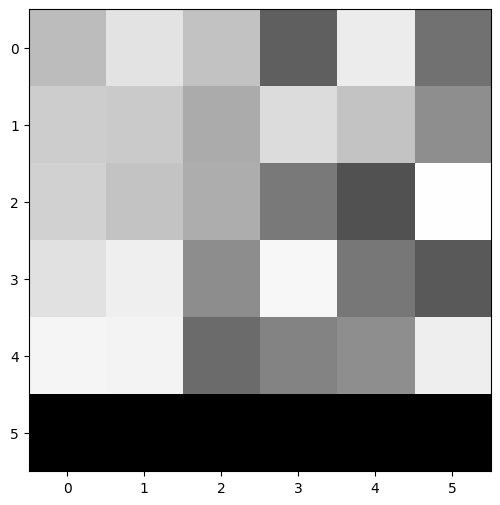

In [56]:
images, labels = generate_dataset_vh(100, (n, n, 1))
train_images, test_images, train_labels, test_labels = train_test_split(
    list(map(reshape_and_rescale, images)), labels, test_size=0.2
)
image = images[15]
print(f"Label: {['horizontal', 'vertical'][(labels[15] + 1) // 2]}")
print(f"Horizontal: {labels.count(-1)}; Vertical: {labels.count(1)}")
plt.imshow(image, cmap="gray", vmin=0, vmax=255)
plt.xticks(np.arange(n), np.arange(n))
plt.yticks(np.arange(n), np.arange(n))
plt.show()

[[  0   0   0   0   0   0]
 [  0   0   1  55  92   0]
 [  0   0  92  98 164   0]
 [  5   6  89 135 118   0]
 [  0   0  73  98   4   0]
 [  0   0   0   0   0   0]]
Label: nine
One: 64; Nine: 56


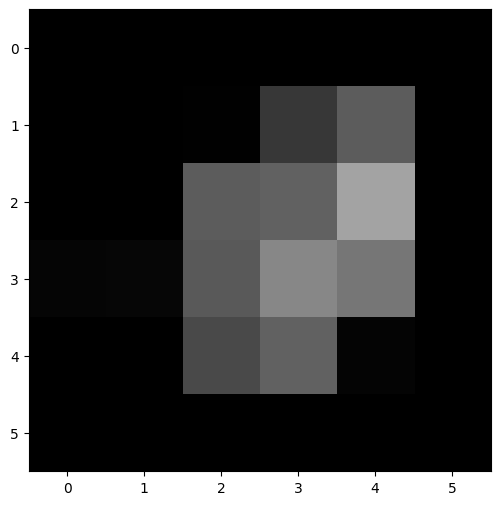

In [65]:
images, labels = get_mnist_data((1, 9), 120)
for i, l in enumerate(labels):
    if l == 1:
        labels[i] = -1
    else:
        labels[i] = 1
train_images, test_images, train_labels, test_labels = train_test_split(
    list(map(reshape_and_rescale, images)), labels, test_size=0.2
)
image = images[18]
print(image)
print(f"Label: {['one', 'nine'][(labels[18] + 1) // 2]}")
print(f"One: {labels.count(-1)}; Nine: {labels.count(1)}")
plt.imshow(image, cmap="gray", vmin=0, vmax=255)
plt.xticks(np.arange(n), np.arange(n))
plt.yticks(np.arange(n), np.arange(n))
plt.show()

In [31]:
def create_classifier_circuit(num_qubits, append_ansatz: bool=False) -> Tuple[QuantumCircuit, List[Parameter], List[Parameter]]:
    qc = QuantumCircuit(num_qubits)
    params = []
    for i in range(num_qubits):
        theta = Parameter(f"theta[{i}]")
        phi = Parameter(f"phi[{i}]")
        gate_x = RXGate(theta=theta)
        gate_z = RZGate(phi=phi)
        qc.append(gate_x, [i])
        qc.append(gate_z, [i])
        params.append(theta)
        params.append(phi)
    ansatz_qc = QuantumCircuit(num_qubits)
    if append_ansatz:
        ans_theta = Parameter(f"ans_theta")
        ans_phi = Parameter(f"ans_phi")
        ansatz_qc.append(
            TwoLocal(
                num_qubits=num_qubits,
                rotation_blocks=[RYGate(theta=ans_theta), RZGate(phi=ans_phi)],
                entanglement_blocks="crz",
                entanglement="linear",
                reps=1,
                insert_barriers=True,
                skip_final_rotation_layer=False,
                parameter_prefix=f"ansatz"
            ).decompose(),
            range(num_qubits)
        )
        qc.barrier()
        qc = qc.compose(
            ansatz_qc, range(num_qubits)
        )
    return qc, params, ansatz_qc.parameters

Original depth: 3, Transpiled depth: 183


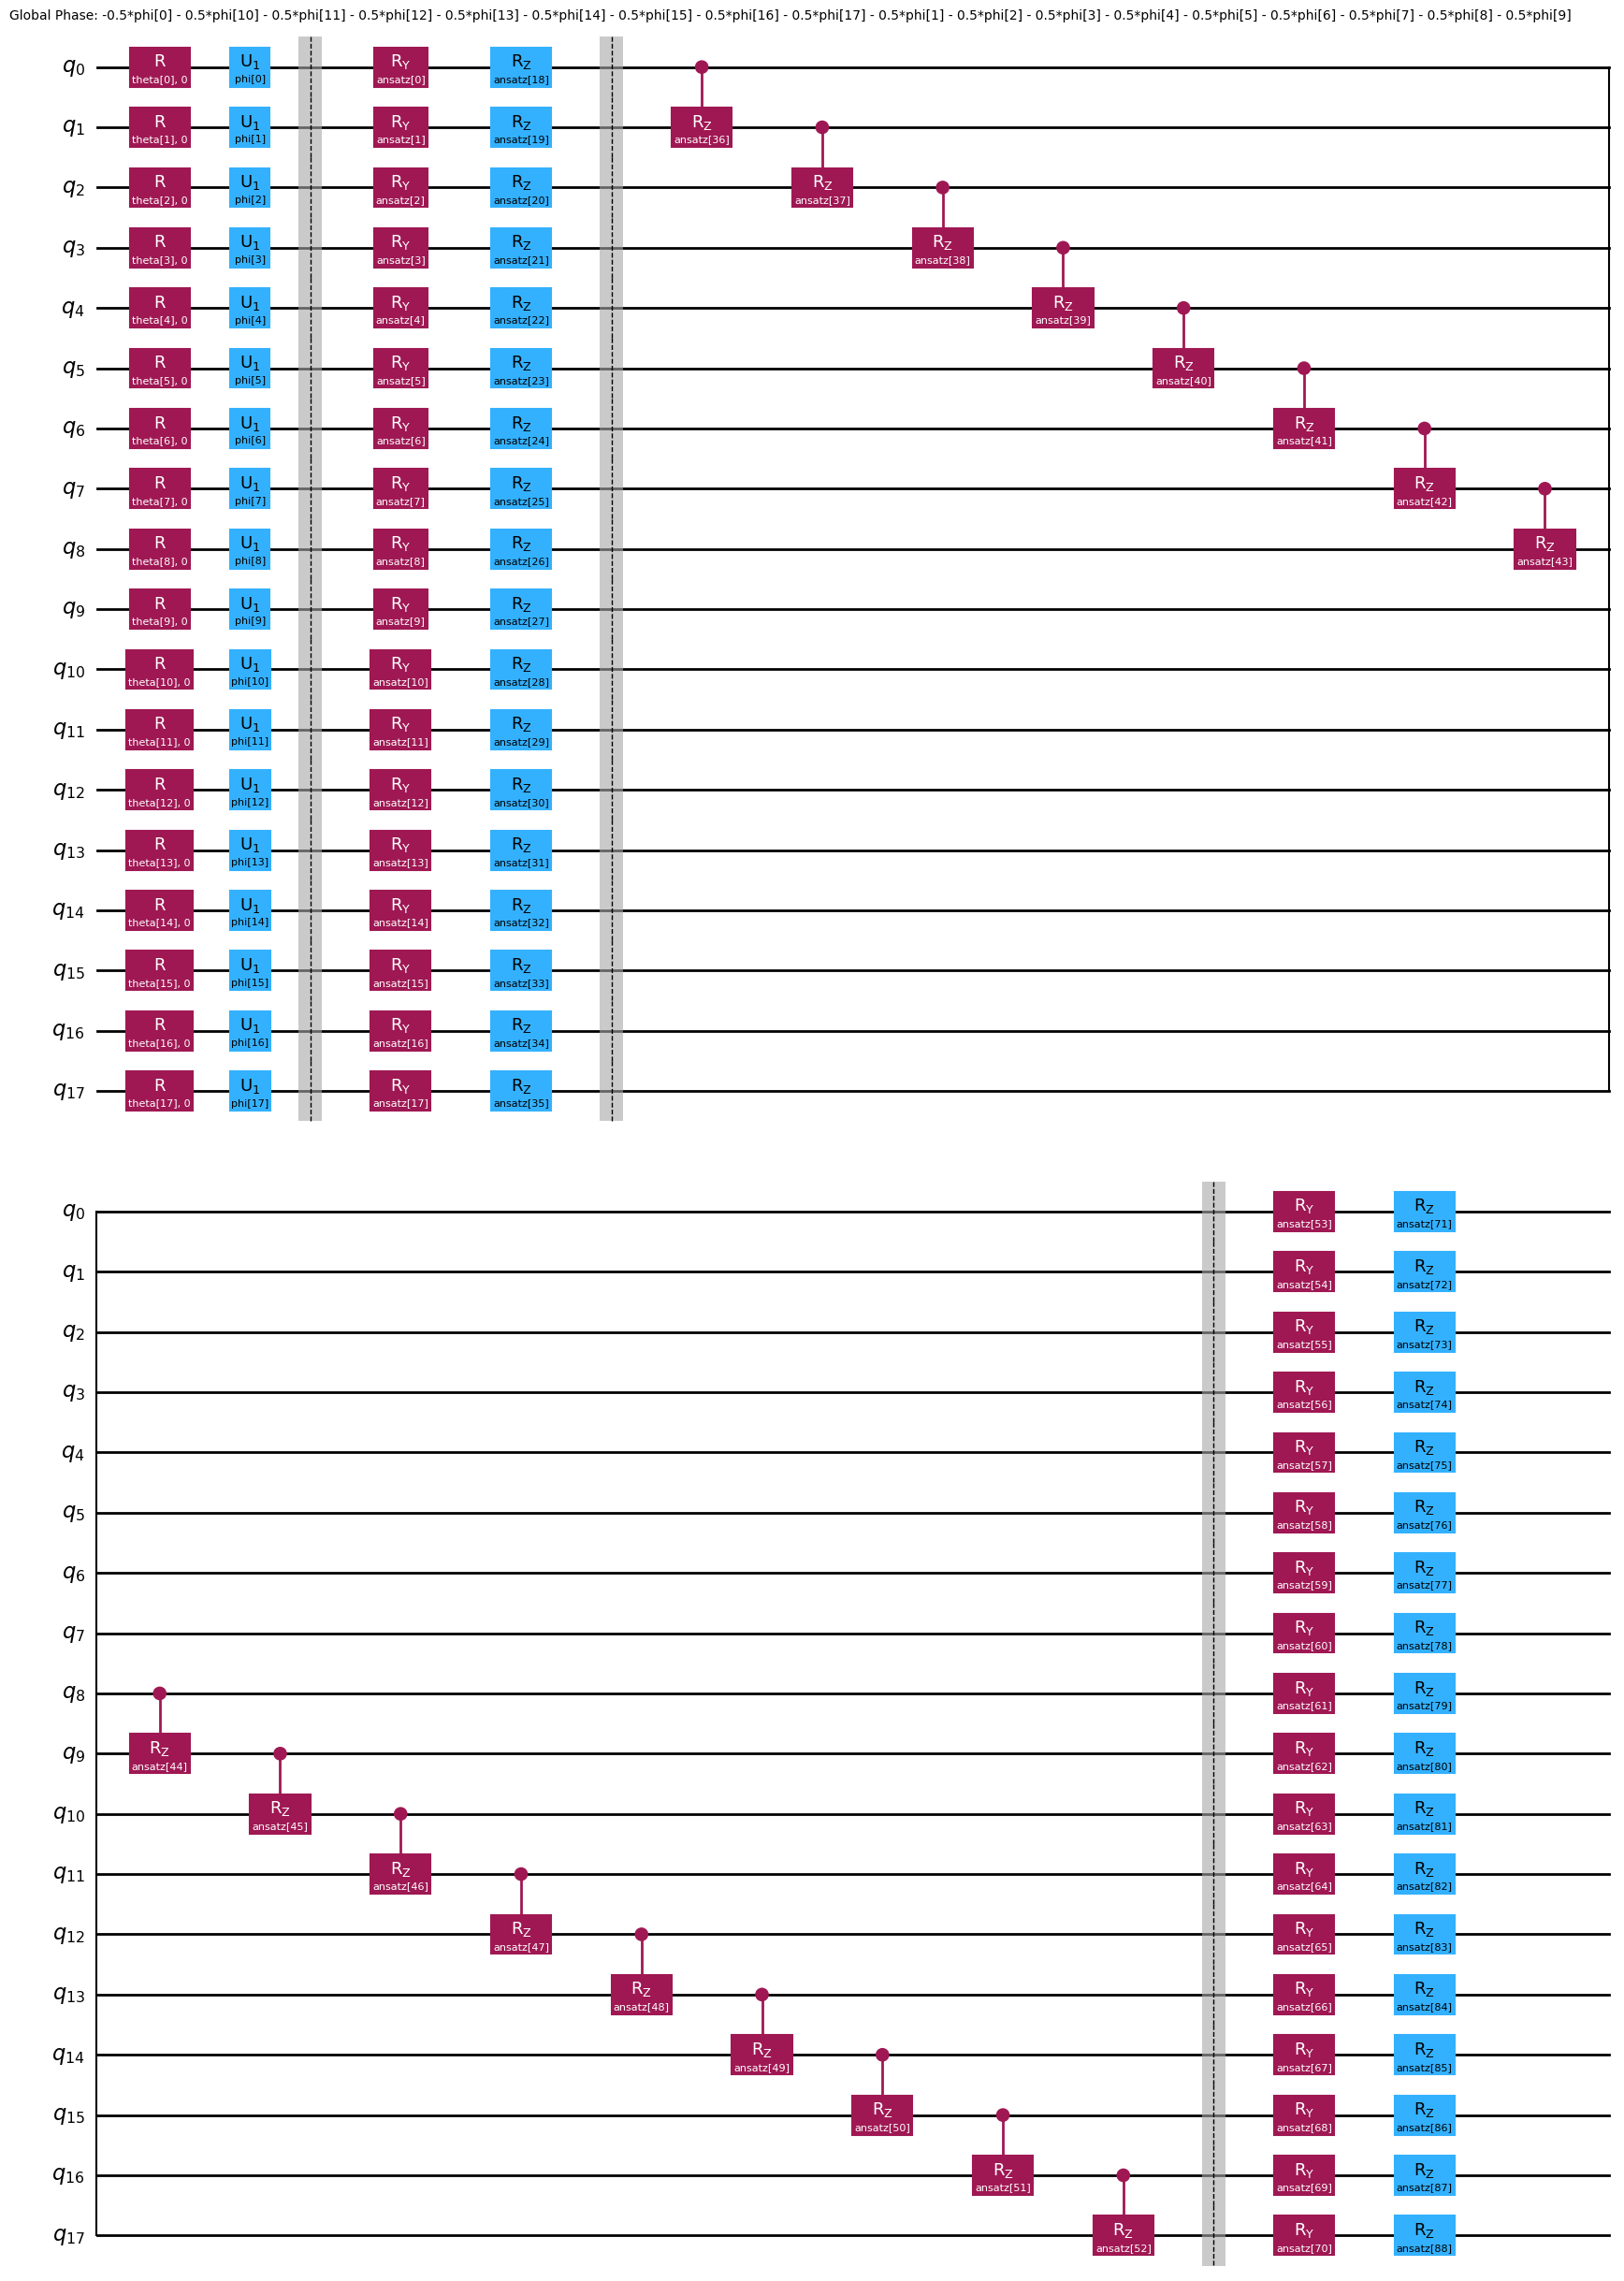

In [59]:
pqc, input_params, weight_params = create_classifier_circuit((n ** 2) // 2, append_ansatz=True)
print(f"Original depth: {pqc.depth()}, Transpiled depth: {transpiled_depth(pqc, 'ibm_kyoto')}")
pqc.decompose().draw("mpl", style="iqp")

In [60]:
arr = []
v = 0
for i in range(n):
    arr += [v] * (n // 2)
    # v = (v + 1) % 2
observables = [
    # SparsePauliOp.from_list([("Z" * (2 ** n), 1)]),
    build_interactions(np.array(arr).reshape((n, n // 2, 1))),
]
print(observables)

6 3
(0, 1) 0 0 6 3
(1, 2) 0 1 6 3
(3, 4) 1 0 6 3
(4, 5) 1 1 6 3
(6, 7) 2 0 6 3
(7, 8) 2 1 6 3
(9, 10) 3 0 6 3
(10, 11) 3 1 6 3
(12, 13) 4 0 6 3
(13, 14) 4 1 6 3
(15, 16) 5 0 6 3
(16, 17) 5 1 6 3
[SparsePauliOp(['ZZIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIII', 'IIIZZIIIIIIIIIIIII', 'IIIIZZIIIIIIIIIIII', 'IIIIIIZZIIIIIIIIII', 'IIIIIIIZZIIIIIIIII', 'IIIIIIIIIZZIIIIIII', 'IIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIZZ', 'ZIIZIIIIIIIIIIIIII', 'IZIIZIIIIIIIIIIIII', 'IIZIIZIIIIIIIIIIII', 'IIIZIIZIIIIIIIIIII', 'IIIIZIIZIIIIIIIIII', 'IIIIIZIIZIIIIIIIII', 'IIIIIIZIIZIIIIIIII', 'IIIIIIIZIIZIIIIIII', 'IIIIIIIIZIIZIIIIII', 'IIIIIIIIIZIIZIIIII', 'IIIIIIIIIIZIIZIIII', 'IIIIIIIIIIIZIIZIII', 'IIIIIIIIIIIIZIIZII', 'IIIIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIIZIIZ', 'IZIZIIIIIIIIIIIIII', 'IIZIZIIIIIIIIIIIII', 'IIIIZIZIIIIIIIIIII', 'IIIIIZIZIIIIIIIIII', 'IIIIIIIZIZIIIIIIII', 'IIIIIIIIZIZIIIIIII', 'IIIIIIIIIIZIZIIIII', 'IIIIIIIIIIIZIZIIII', 'IIIIIIIIIIIIIZIZII

In [61]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

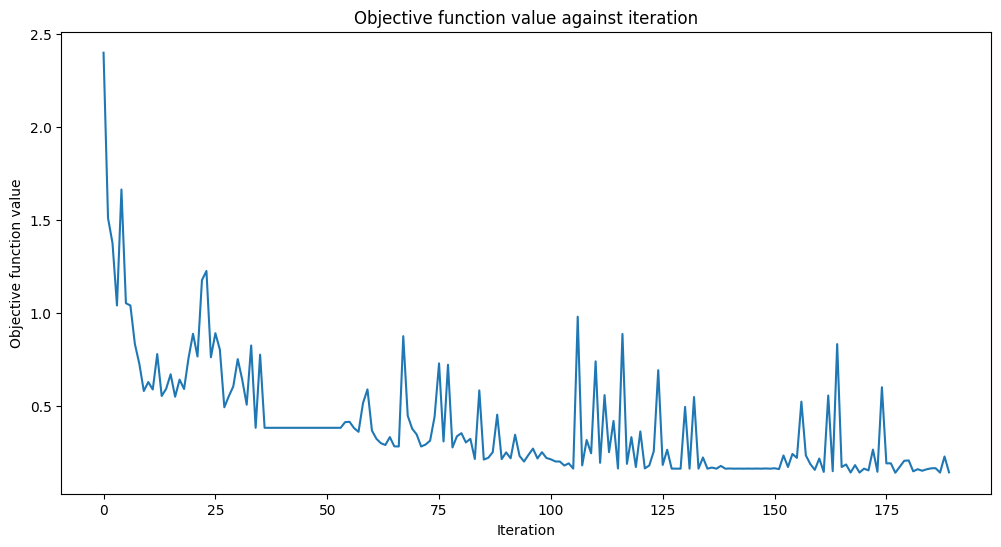

Accuracy from the train data : 96.88%


In [66]:
with Session(service=service, backend="ibm_osaka", max_time="12m") as session:
    estimator = None # Estimator(session=session)
    qnn = EstimatorQNN(
        estimator=estimator,
        circuit=pqc.decompose(),
        observables=observables[0],
        input_params=input_params,
        weight_params=weight_params,
    )
    classifier = NeuralNetworkClassifier(
        qnn,
        optimizer=COBYLA(maxiter=190),  # Set max iterations here
        callback=callback_graph,
        #initial_point=np.ones(len(weight_params)),
        initial_point=np.random.random(len(weight_params)) * np.pi,
        #initial_point=classifier.weights,
    )
    x = np.asarray(train_images)
    y = np.asarray(train_labels)

    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)
    classifier.fit(x, y)

    # score classifier
    print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [67]:
print(classifier.weights)
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

[ 1.58902319  2.03433539  0.74082158  1.56033208  1.63798406  4.04520475
  4.05191583  1.01904009  1.21644996  3.8723854   1.20873744  1.12429054
  4.0896076   0.66840317  3.06992368  3.68380325  1.97310162  1.62605541
  0.878042    2.94069966  1.62127279  1.69779638  0.34752355  1.29166685
  0.36627254  1.93104844  3.19482784  0.03977803  3.0499863   2.2291282
  2.69495586  2.53749101  0.89284913  1.84583873  0.40503901  3.02676788
  0.14002382  1.09240843  2.67564286  1.6586842   1.87948428  2.03745834
  3.43927635  0.37486098  2.0066418   0.69927338  0.37518442  1.99752269
  0.20874048  1.55113936  3.01659594  2.53140181  2.50770643  1.82742141
  2.80859725  1.690553    2.88428784  2.69796303  0.17168515  2.74474234
  4.14479101  2.67291315  4.09029702  2.88428944  3.83577582  2.80567127
  0.24901228  0.81353443  0.2035731   2.71646568  2.65557506 -0.31886759
  2.01907891  0.0107763   0.39437035  1.77370573  0.60422496  4.02309245
  1.4490547   1.52283577  0.6901998   0.41213117  1.

In [ ]:
plt.imshow(images[0], cmap="gray")

In [72]:
from qiskit.providers.aer.noise import NoiseModel
NoiseModel()

<NoiseModel on []>

In [73]:
import qiskit.version

In [74]:
qiskit.version.get_version_info()

'0.45.0'

In [75]:
!pip list

Package                   Version
------------------------- ------------
anyio                     4.0.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     23.1.0
Babel                     2.13.1
beautifulsoup4            4.12.2
bleach                    6.1.0
certifi                   2023.7.22
cffi                      1.16.0
charset-normalizer        3.3.2
colorama                  0.4.6
comm                      0.2.0
contourpy                 1.2.0
cryptography              41.0.7
cycler                    0.12.1
debugpy                   1.8.0
decorator                 5.1.1
defusedxml                0.7.1
dill                      0.3.7
exceptiongroup            1.1.3
executing                 2.0.1
fastdtw                   0.3.4
fastjsonschema            2.19.0
fonttools                 4.44.3
fqdn                      1.5.1
h5py             


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip
